In [1]:
%matplotlib inline

from imports import *  # shortcut for standard imports

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [10]:
source = '/home/sobolev/nevermind/Andrey/data'
report = '/home/sobolev/nevermind/Andrey/analysis/hippoSIT'

#session  = '008229_hippoSIT_2022-07-01_14-07-59'
#session  = '008229_hippoSIT_2022-05-17_21-44-43'
#session  = '008229_hippoSIT_2022-05-16_20-36-44'
#session  = '008229_hippoSIT_2022-05-20_15-54-39'
#session  = '008229_hippoSIT_2022-05-18_14-36-18'
#session  = '008229_hippoSIT_2022-05-31_11-00-02'
#session  = '008229_hippoSIT_2022-05-31_16-38-23'
#session  = '008229_hippoSIT_2022-06-01_11-08-51'
#session  = '008229_hippoSIT_2022-06-25_17-49-10'
#session  = '008229_hippoSIT_2022-06-28_10-12-19'
#session  = '008229_hippoSIT_2022-06-28_21-03-46'
#session  = '008229_hippoSIT_2022-06-29_19-47-35'
#session  = '008228_hippoSIT_2022-06-25_16-57-49'
#session  = '008228_hippoSIT_2022-06-27_15-27-49'
#session  = '008228_hippoSIT_2022-05-28_12-20-33'
#session  = '008228_hippoSIT_2022-06-01_10-19-39'
#session = '008229_hippoSIT_2022-07-01_14-07-59'
#session = '008228_hippoSIT_2022-07-04_15-19-35'
session = '008229_hippoSIT_2022-07-01_14-07-59'

unit_name = '5-4'

animal  = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5name  = os.path.join(source, animal, session, session + '.h5')

## Spiketrain

In [4]:
extent = (-0.5, 0.5, -0.5, 0.5)
limits = (extent[0], extent[1], extent[2], extent[3])
epochs = cleaned_epochs(sessionpath)

with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    o_maps    = np.array(f['units'][unit_name][H5NAMES.o_maps['name']])
    f_maps    = np.array(f['units'][unit_name][H5NAMES.f_maps['name']])
    o_info    = np.array(f['units'][unit_name][H5NAMES.occ_info['name']])
    f_info    = np.array(f['units'][unit_name][H5NAMES.spat_info['name']])
    o_COM     = np.array(f['units'][unit_name][H5NAMES.o_COM['name']])
    f_COM     = np.array(f['units'][unit_name][H5NAMES.f_COM['name']])
    f_PFR     = np.array(f['units'][unit_name][H5NAMES.pfr_center['name']])
    peak_FR   = np.array(f['units'][unit_name][H5NAMES.peak_FR['name']])
    s_idxs = np.array(f['units'][unit_name][H5NAMES.spike_idxs['name']])
    i_rate = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])

    s_times = np.array(f['units'][unit_name][H5NAMES.spike_times['name']])
    
    cfg = json.loads(f['processed'].attrs['parameters'])
    arena_r = float(cfg['position']['floor_r_in_meters'])
    
#s_times = tl[s_idxs][:, 0]
values = np.random.rand(len(s_times))

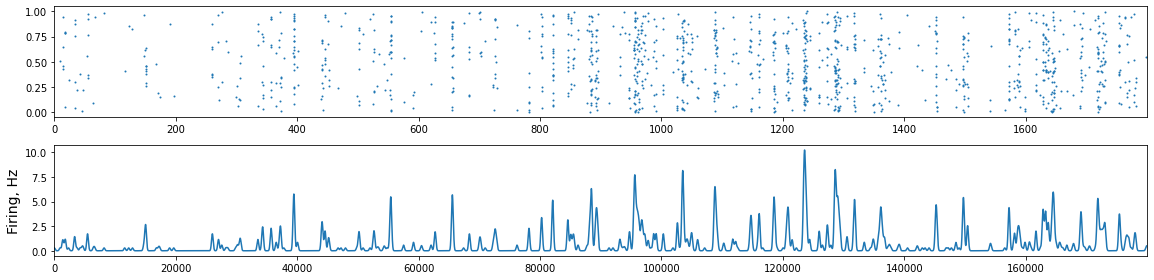

In [5]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(211)
ax.scatter(s_times, values, s=1)
ax.set_xlim(tl[0][0], tl[-1][0])

ax = fig.add_subplot(212)
ax.plot(i_rate)
ax.set_xlim(0, len(i_rate))
ax.set_ylabel('Firing, Hz', fontsize=14)

fig.tight_layout()

## Spiking maps

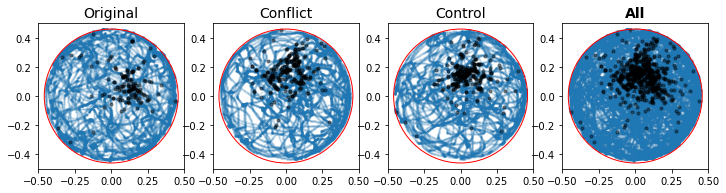

In [6]:
col_no = len(epochs)
fig = plt.figure(figsize=(3*col_no, 3))

for i, epoch in enumerate(epochs):
    run_idxs = np.where(tl[:, 3] > 0.04)[0]
    
    # animal positions
    a_pos = tl[run_idxs]  # speed filter
    a_pos = a_pos[(a_pos[:, 0] > epoch[0]) & (a_pos[:, 0] < epoch[1])] 
    
    # spike positions
    s_pos = tl[np.intersect1d(run_idxs, s_idxs)]
    s_pos = s_pos[(s_pos[:, 0] > epoch[0]) & (s_pos[:, 0] < epoch[1])] 

    ax = fig.add_subplot(1, col_no, i+1)
    ax.set_xlim(limits[0], limits[1])
    ax.set_ylim(limits[2], limits[3])
    ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
    ax.scatter(a_pos[:, 1], a_pos[:, 2], alpha=0.1, s=2)
    ax.scatter(s_pos[:, 1], s_pos[:, 2], alpha=0.4, s=10, c='black')
    ax.set_aspect('equal')
    ax.set_title(EPOCH_NAMES[i], fontsize=14, weight='bold' if i == len(epochs) - 1 else 'normal')

## Place fields

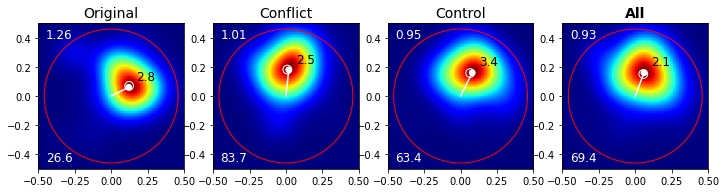

In [7]:
col_no = len(f_maps)
fig = plt.figure(figsize=(3*col_no, 3))

for i, f_map in enumerate(f_maps):
    x_COM, y_COM = pol2cart(f_COM[i][0], f_COM[i][1])
    x_PFR, y_PFR = pol2cart(f_PFR[i][0], f_PFR[i][1])
    
    ax = fig.add_subplot(1, col_no, i+1)
    ax.set_xlim(limits[0], limits[1])
    ax.set_ylim(limits[2], limits[3])
    ax.imshow(f_map.T, cmap='jet', origin='lower', extent=extent)
    ax.plot([0, x_PFR], [0, y_PFR], color='white')
    ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
    ax.add_patch(plt.Circle((x_COM, y_COM), 0.03, color='white', fill=False))
    ax.add_patch(plt.Circle((x_PFR, y_PFR), 0.02, color='white', fill=True))
    ax.text(-0.45, 0.4, round(f_info[i], 2), color='white', fontsize=12)  # spatial info in the corner
    ax.text(-0.45, -0.45, round(np.rad2deg(f_PFR[i][1]), 1), color='white', fontsize=12)  # spatial info in the corner
    ax.text(x_PFR + 0.05, y_PFR + 0.05, round(peak_FR[i], 1), color='black', fontsize=12)  # peak firing rate
    ax.set_title(EPOCH_NAMES[i], fontsize=14, weight='bold' if i == len(f_maps) - 1 else 'normal')

## Place field evolution

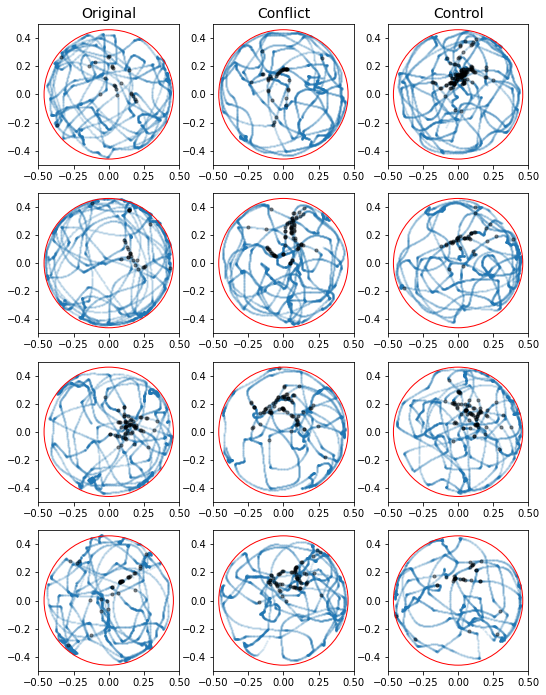

In [1223]:
# compute COM evolution by ~2 min bins
col_no = len(epochs)
row_no = 5
fig = plt.figure(figsize=(3*col_no, 3*row_no))

for i, epoch in enumerate(epochs[:3]):
    time_bins = np.repeat(np.arange(150, 600, 150), 2).astype(np.float64)
    time_bins += epoch[0]
    time_bins = np.array([epoch[0]] + list(time_bins) + [epoch[1]])
    time_bins= time_bins.reshape([int(len(time_bins)/2), 2])

    run_idxs = np.where(tl[:, 3] > 0.04)[0]

    for j, t_bin in enumerate(time_bins):
        # animal positions
        a_pos = tl[run_idxs]  # speed filter
        a_pos = a_pos[(a_pos[:, 0] > t_bin[0]) & (a_pos[:, 0] < t_bin[1])] 

        # spike positions
        s_pos = tl[np.intersect1d(run_idxs, s_idxs)]
        s_pos = s_pos[(s_pos[:, 0] > t_bin[0]) & (s_pos[:, 0] < t_bin[1])] 
    
        ax = fig.add_subplot(row_no, col_no, j*col_no + i+1)
        ax.set_xlim(limits[0], limits[1])
        ax.set_ylim(limits[2], limits[3])
        ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
        ax.scatter(a_pos[:, 1], a_pos[:, 2], alpha=0.1, s=2)
        ax.scatter(s_pos[:, 1], s_pos[:, 2], alpha=0.4, s=10, c='black')
        ax.set_aspect('equal')
        if j == 0:
            ax.set_title(EPOCH_NAMES[i], fontsize=14, weight='bold' if i == len(epochs) - 1 else 'normal')

## Multiple PFs

In [8]:
unit_infos = [
    ['008229_hippoSIT_2022-07-01_14-07-59', '1-2'],
    ['008229_hippoSIT_2022-07-01_14-07-59', '1-4'],
    ['008229_hippoSIT_2022-07-01_14-07-59', '1-5'],
    ['008229_hippoSIT_2022-07-01_14-07-59', '1-8'],
    #['008229_hippoSIT_2022-07-01_14-07-59', '1-12'],
    #['008229_hippoSIT_2022-07-01_14-07-59', '1-14'],
    ['008229_hippoSIT_2022-07-01_14-07-59', '1-17'],
    #['008229_hippoSIT_2022-07-01_14-07-59', '1-18'],
    ['008229_hippoSIT_2022-07-01_14-07-59', '1-20'],
    ['008229_hippoSIT_2022-07-01_14-07-59', '1-21'],
    ['008229_hippoSIT_2022-07-01_14-07-59', '1-22'],
    ['008229_hippoSIT_2022-07-01_14-07-59', '4-2'],
    #['008229_hippoSIT_2022-07-01_14-07-59', '4-3'],
    ['008229_hippoSIT_2022-07-01_14-07-59', '5-4'],
]

90


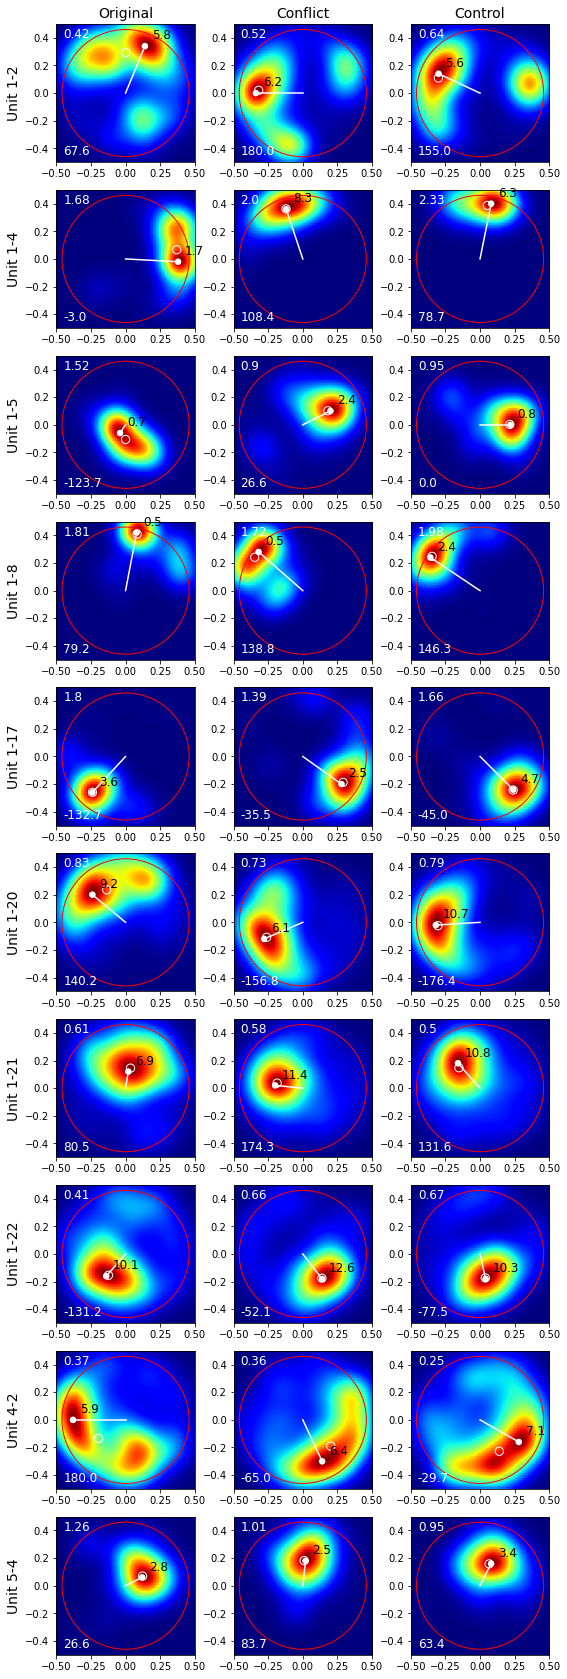

In [18]:
extent = (-0.5, 0.5, -0.5, 0.5)
limits = (extent[0], extent[1], extent[2], extent[3])
epochs = cleaned_epochs(sessionpath)
row_no, col_no = len(unit_infos), 3
fig = plt.figure(figsize=(3*col_no, 3*row_no))

for j, unit_info in enumerate(unit_infos):
    h5name  = os.path.join(source, animal, unit_info[0], unit_info[0] + '.h5')
    unit_name = unit_info[1]
    
    with h5py.File(h5name, 'r') as f:
        #tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
        #o_maps    = np.array(f['units'][unit_name][H5NAMES.o_maps['name']])
        f_maps    = np.array(f['units'][unit_name][H5NAMES.f_maps['name']])
        #o_info    = np.array(f['units'][unit_name][H5NAMES.occ_info['name']])
        f_info    = np.array(f['units'][unit_name][H5NAMES.spat_info['name']])
        #o_COM     = np.array(f['units'][unit_name][H5NAMES.o_COM['name']])
        f_COM     = np.array(f['units'][unit_name][H5NAMES.f_COM['name']])
        f_PFR     = np.array(f['units'][unit_name][H5NAMES.pfr_center['name']])
        peak_FR   = np.array(f['units'][unit_name][H5NAMES.peak_FR['name']])
        #s_idxs = np.array(f['units'][unit_name][H5NAMES.spike_idxs['name']])
        #i_rate = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])
        cfg = json.loads(f['processed'].attrs['parameters'])
        arena_r = float(cfg['position']['floor_r_in_meters'])
    
    for i, f_map in enumerate(f_maps[:3]):
        x_COM, y_COM = pol2cart(f_COM[i][0], f_COM[i][1])
        x_PFR, y_PFR = pol2cart(f_PFR[i][0], f_PFR[i][1])

        ax = fig.add_subplot(row_no, col_no, 3*j + i+1)
        ax.set_xlim(limits[0], limits[1])
        ax.set_ylim(limits[2], limits[3])
        ax.imshow(f_map.T, cmap='jet', origin='lower', extent=extent)
        ax.plot([0, x_PFR], [0, y_PFR], color='white')
        ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
        ax.add_patch(plt.Circle((x_COM, y_COM), 0.03, color='white', fill=False))
        ax.add_patch(plt.Circle((x_PFR, y_PFR), 0.02, color='white', fill=True))
        ax.text(-0.45, 0.4, round(f_info[i], 2), color='white', fontsize=12)  # spatial info in the corner
        ax.text(-0.45, -0.45, round(np.rad2deg(f_PFR[i][1]), 1), color='white', fontsize=12)  # spatial info in the corner
        ax.text(x_PFR + 0.05, y_PFR + 0.05, round(peak_FR[i], 1), color='black', fontsize=12)  # peak firing rate
        if j == 0:
            ax.set_title(EPOCH_NAMES[i], fontsize=14, weight='bold' if i == len(f_maps) - 1 else 'normal')
        if i == 0:
            ax.set_ylabel("Unit %s" % unit_info[1], fontsize=14)

#fig.tight_layout()
fig.savefig(os.path.join(report, 'PFs_%s.pdf' % session))
print(cfg['experiment']['phi_max'])

In [14]:
def to_minus_pi_and_pi(angle):
    angle_r = angle % 360
    if angle_r > 180:
        return -(360 - angle_r)
    return angle_r

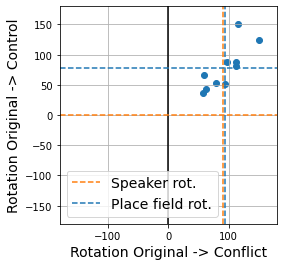

In [17]:
pairs = []
for j, unit_info in enumerate(unit_infos):
    h5name  = os.path.join(source, animal, unit_info[0], unit_info[0] + '.h5')
    unit_name = unit_info[1]
    
    with h5py.File(h5name, 'r') as f:
        f_PFR = np.array(f['units'][unit_name][H5NAMES.pfr_center['name']])
    
    x = np.rad2deg(f_PFR[1][1]) - np.rad2deg(f_PFR[0][1])
    y = np.rad2deg(f_PFR[2][1]) - np.rad2deg(f_PFR[0][1])
    
    x = to_minus_pi_and_pi(x)
    y = to_minus_pi_and_pi(y)
    pairs.append([x, y])
    
    
pairs = np.array(pairs)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(pairs[:, 0], pairs[:, 1])
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_aspect('equal')
#ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.axhline(0, color=COLORS[1], ls='--', label='Speaker rot.')
ax.axvline( cfg['experiment']['phi_max'], color=COLORS[1], ls='--')
ax.axhline(pairs[:, 1].mean(), color=COLORS[0], ls='--', label='Place field rot.')
ax.axvline(pairs[:, 0].mean(), color=COLORS[0], ls='--')
ax.grid()
ax.set_xlabel('Rotation Original -> Conflict', fontsize=14)
ax.set_ylabel('Rotation Original -> Control', fontsize=14)
ax.legend(loc='lower left', fontsize=14)
fig.savefig(os.path.join(report, 'PF_rotations_%s.png' % session))

In [42]:
pairs

array([[112.38013505,  87.36324157],
       [111.44773633,  81.70285503],
       [150.2551187 , 123.69006753],
       [ 59.5983727 ,  67.09423034],
       [ 97.17171217,  87.70938996],
       [ 63.00416161,  43.38190547],
       [ 93.75172907,  51.09586154],
       [ 79.06090882,  53.71473287],
       [115.01689348, 150.2551187 ],
       [ 57.09475708,  36.86989765]])